In [41]:
import pandas as pd
import numpy as np
import utm
from datetime import datetime

def load_flujo_files(filename):
    datos = pd.read_csv(filename,sep=";")
    datos = datos.iloc[1000:3600] #first 3700 rows have data
    dates = datos["HORA"]
    # formated = []
    # for date in dates:
    #     formated.append(datetime.strptime(date, '%d/%m/%y %H:%M:%S').strftime('%Y/%m/%d %H:%M:%S'))
   
    datos["DATETIME"] = dates #formated
    datos = datos[["DATETIME","LATITUD","LONGITUD","ALTITUD","VELOCIDAD","CONSUMO_TOTAL","CPNSUMO_INSTANTANEO"]]
    datos.dropna(inplace=True)
    datos["LATITUD"] = pd.to_numeric(datos.LATITUD.str.slice(0, 6) + datos.LATITUD.str.slice(7, ))
    datos = datos[datos.LATITUD<0]
    datos["LONGITUD"] = pd.to_numeric(datos.LONGITUD.str.slice(0, 7) + datos.LONGITUD.str.slice(8, ))
    datos = datos[datos.LONGITUD<0]    
    datos = datos[(datos["ALTITUD"]<4000) & (datos["ALTITUD"]>1800)]
    return datos

In [42]:
import pandas as pd
import numpy as np
import utm
import matplotlib.pyplot as plt

def process_data(latitude_array, longitude_array, height_array, date_array, utmzone, speed_array, consumo_array, consumo_instantaneo) :
    #1. UTM Coordinates
    min_distance = 0.01
    zone = utmzone.split(" ")
    zonenum = int(zone[0])
    zoneletter = zone[1]
    utms = utm.from_latlon(latitude_array,longitude_array,zonenum,zoneletter) #14Q for Mexico, 17S for Ecuador    
    utm_x = utms[0]
    utm_y = utms[1]
    last_utm_x = utm_x.shift(1) #last observation
    last_utm_y = utm_y.shift(1)
    last_height = height_array.shift(1)
    mean_height_diff = np.mean(np.abs(last_height-height_array))
    print("Average height difference:",mean_height_diff)
    distances = np.sqrt((utm_x-last_utm_x)**2 + (utm_y-last_utm_y)**2)+min_distance
    slopes = (height_array-last_height)/distances
    sumdistances = np.cumsum(distances)
    
    new_data = pd.DataFrame({"latitude":latitude_array, "longitude":longitude_array,\
                                "height":height_array, "distance":distances, "sum_distance":sumdistances,\
                                "slope":slopes, "date":date_array, "utm_x":utm_x, "utm_y":utm_y, \
                                "velocidad_gps":speed_array, "consumo_total":consumo_array, "consumo_inst":consumo_instantaneo
                                    })
    
    return new_data

In [43]:

def calc_slopes(utm_x, utm_y, height_array) :
    #1. UTM Coordinates
    min_distance = 0.01    
    last_utm_x = utm_x.shift(1) #last observation
    last_utm_y = utm_y.shift(1)
    last_height = height_array.shift(1)
    mean_height_diff = np.mean(np.abs(last_height-height_array))
    print("Average height difference:",mean_height_diff)
    distances = np.sqrt((utm_x-last_utm_x)**2 + (utm_y-last_utm_y)**2)+min_distance
    slopes = (height_array-last_height)/distances
    sumdistances = np.cumsum(distances)
    
    new_data = pd.DataFrame({"distance":distances, "sum_distance":sumdistances, "slope":slopes})
    
    return new_data

In [45]:
from datetime import datetime
import time

def add_speeds(datos, calctimestamp=True):
    
    # if calctimestamp==True:
    #     dates= datos["date"]
    #     datos["timestamp"] = 0
    #     formated = []
    #     for d in dates:
    #         formated.append(datetime.strptime(str(d) , "%Y/%m/%d %H:%M:%S").timestamp())   
    #     datos["timestamp"] = formated
    # last_timestamps = datos["timestamp"].shift(1)
    # datos['ds'] =  datos["timestamp"]-last_timestamps

    if calctimestamp==True:
        formated = []
        dates= datos["date"]    
        i = 1
        for d in dates:
            f = datetime.strptime(str(d) , "%H:%M:%S")
            if i>1:
                formated.append((f-fant).seconds)
            else:
                formated.append(0)
            fant = f
            i = i + 1
        datos['ds'] = formated
    datos['velocidad'] = datos['distance']/datos['ds']
    datos = datos.tail(-10) #first instances with errors
    return datos.dropna()

In [46]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)-1):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters    
    return data

In [47]:
def tol_adjust (data, tol=1.9): #empezar con tolerance igual al promedio de alturas 
  #entre puntos consecutivos aproximadamente
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec<3].shape[0] #number of vey small clusters (forbidden in order to regression to work)
  print('Min gap distance',tol)
  return data2  


In [48]:
from sklearn.linear_model import LinearRegression
from datetime import datetime
import math

#def height_correction(data_clustered, max_points=5,max_distance=0.5):
def height_correction(data_clustered, max_points=5):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        gps_smooth = pd.DataFrame()
        for i in range(1,len(clusters)):
            #take pair of clusters
            data_clustered['old_height'] = data_clustered['height'] 
            data_clustered['old_utm_x'] = data_clustered['utm_x']  
            data_clustered['old_utm_y'] = data_clustered['utm_y']   
            #data_clustered['old_timestamp'] = data_clustered['timestamp']  
            grupo1 = data_clustered[data_clustered['cluster']==i].copy()
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)].copy()
            m = np.min([(math.floor(grupo1.shape[0]/2)-1),(math.floor(grupo1.shape[0]/2)-1),max_points])
            #m = np.min([grupo1.shape[0],grupo2.shape[0],max_points])

            #take last and first m points  (important to not include borders which are outliers)
            subgrupo1 = grupo1[:-1].tail(m+1)
            subgrupo2 = grupo2.iloc[1:m] 

            #regression points = 2m
            r = pd.concat([subgrupo1,subgrupo2]).reset_index(drop=True)
           
            modelo_z = LinearRegression().fit(r[['sum_distance']],r[['height']])
            modelo_x = LinearRegression().fit(r[['sum_distance']],r[['utm_x']])
            modelo_y = LinearRegression().fit(r[['sum_distance']],r[['utm_y']])
            #modelo_t = LinearRegression().fit(r[['sum_distance']],r[['timestamp']])
            last_consum = subgrupo1.consumo_total.max()
            last_speed = subgrupo1.velocidad_gps.max()
            last_date = subgrupo1.tail(1).date
            #modelo_c = LinearRegression().fit(r[['sum_distance']],r[['consumo_total']])
                    
            #reemplazar con suavizado
            x_min = r.sum_distance.min()
            x_max = r.sum_distance.max()
            #replace_points = math.ceil((r.sum_distance.max()-r.sum_distance.min())/max_distance)
            #replace_points = r.shape[0]+2
            #replace_points = regression points + 4 = 2m + 2

            gap_points = pd.concat([grupo1.tail(m+1),grupo2.head(m+1)])
            replace_points = gap_points.shape[0]
            gap_points.sum_distance = np.linspace(x_min,x_max,replace_points)
     
            h_smooth = modelo_z.predict(gap_points[['sum_distance']])
            gap_points['height']=h_smooth         
            x_smooth = modelo_x.predict(gap_points[['sum_distance']])
            gap_points['utm_x']=x_smooth
            y_smooth = modelo_y.predict(gap_points[['sum_distance']])
            gap_points['utm_y']=y_smooth  
            #t_smooth = modelo_t.predict(gap_points[['sum_distance']])
            #gap_points['timestamp']=t_smooth    
            # gap_points['date']= [last_date]*len(gap_points)
            # #c_smooth = modelo_c.predict(gap_points[['sum_distance']])
            # gap_points['consumo_total']=last_consum     
            # gap_points['velocidad_gps']=last_speed
            # gap_points['secuencia']=0
            # gap_points['distance']=0
            # gap_points['slope']=0
            # gap_points['cluster']=0
            # gap_points['consumo_inst']=0
            
            #Ejemplo con m = 2
            if i==1: #0 1 2 3 4 5 6 (7 8 [9]) ([0] 1 2) 3 4 5 6 7 8 9
                gps_smooth = pd.concat([gps_smooth,grupo1[0:(grupo1.shape[0] - (m+2))],gap_points])    
            else: 
                gps_smooth = pd.concat([gps_smooth,grupo1[last_m+1:(grupo1.shape[0] - (m+2))],gap_points])   
            last_m = m

        gps_smooth = pd.concat([gps_smooth,  grupo2[last_m+1:(grupo2.shape[0] -1)]])

  
    else:
        print("WARNING: No gaps found (clusters number must be longer than 1")
    
    #gps_smooth = gps_smooth.tail(-1)
    return(gps_smooth.reset_index(drop=True))

Cargar datos y mostrar alturas

Average height difference: 1.8522745098039213


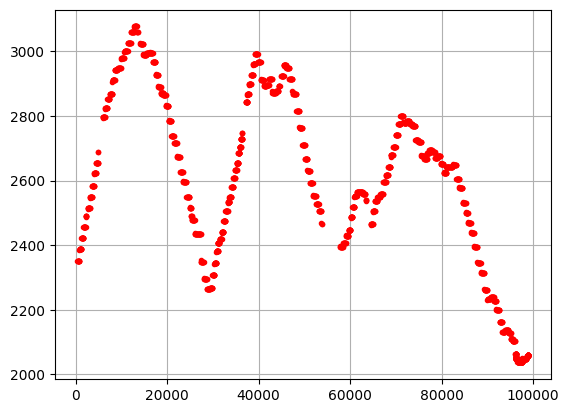

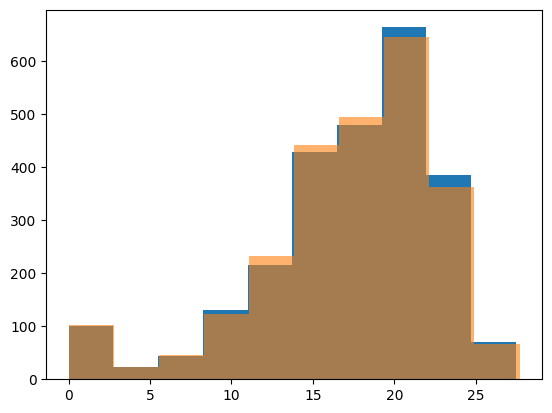

In [49]:
import matplotlib.pyplot as plt

datos = load_flujo_files("datasets/flujo_15_8_2017.csv")
datos = process_data(datos["LATITUD"],datos["LONGITUD"],datos["ALTITUD"],datos["DATETIME"],"17 S",\
                      datos["VELOCIDAD"],datos["CONSUMO_TOTAL"],datos["CPNSUMO_INSTANTANEO"])
datos.dropna(inplace=True)
datos = add_speeds(datos)
datos_l = datos.reset_index(drop=True)
datos_l.to_csv("datos_sincorregir.csv", index=False)
plt.plot(datos_l["sum_distance"],datos_l["height"],"r.")
plt.grid()
plt.show()
plt.hist(datos_l["velocidad_gps"]*1000/3600)
plt.hist(datos_l["velocidad"],alpha=0.6)
plt.show()

Clustering Inicial para hallar errores

Min gap distance 33.400000000000205


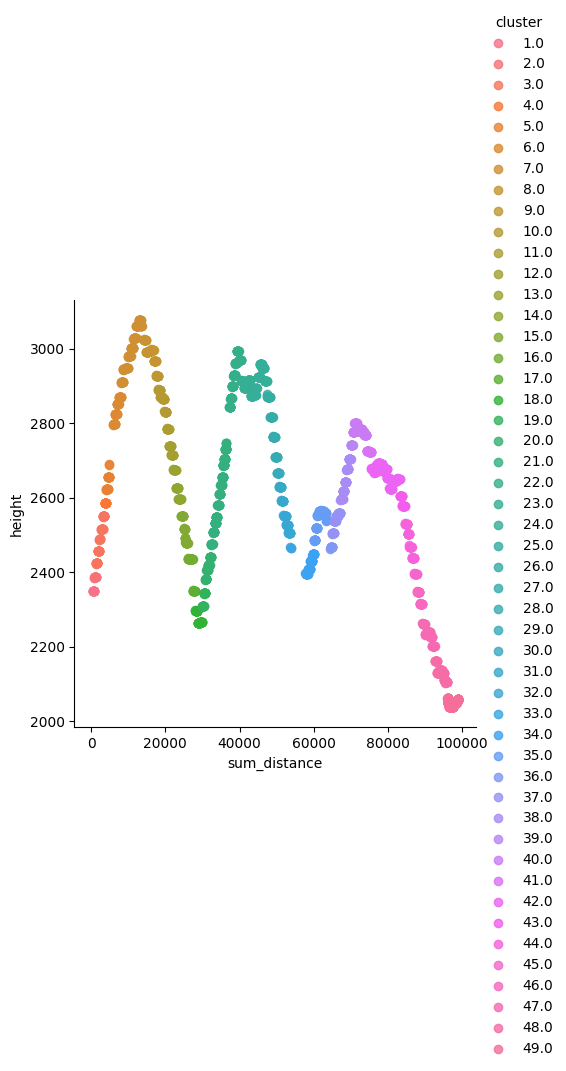

In [50]:
import seaborn as sns

data_clustered = tol_adjust(datos_l, 1.9)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)

Corrección de alturas

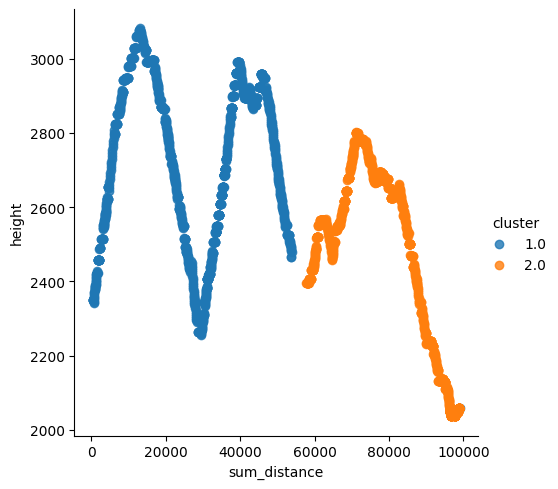

In [51]:

#data_smooth = height_correction(data_clustered,10,17)
data_smooth = height_correction(data_clustered,10)
data_clustered = sdd_clust(data_smooth, 33.5) #use min gap distance in previous step
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)


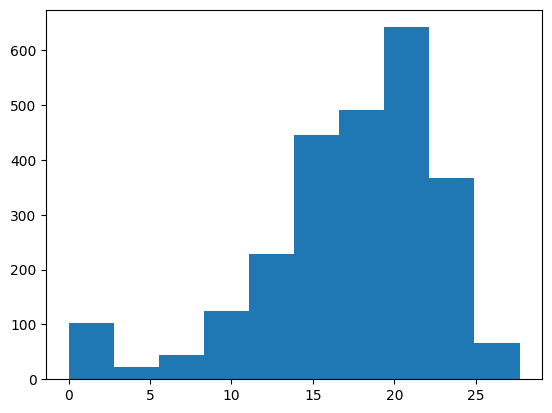

In [52]:
plt.hist(data_clustered.velocidad)
plt.show()

Producir archivo final corregido

Average height difference: 2.4531312501688265


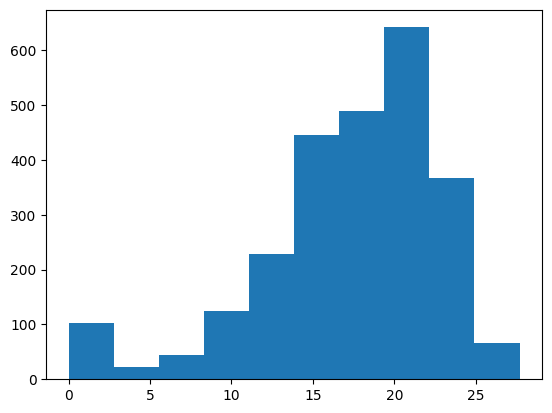

In [57]:

data_clustered = data_clustered[["date", "height","old_height", "utm_x","utm_y","distance","slope","sum_distance","velocidad","ds","velocidad_gps","consumo_total","consumo_inst"]]

xs = np.array(data_clustered["utm_x"])
ys = np.array(data_clustered["utm_y"])
utms = utm.to_latlon(xs,ys,17,northern=False) #14Q for Mexico, 17S for Ecuador
data_clustered["latitud"] = utms[0]
data_clustered["longitud"] = utms[1] 
nuevosdatos = calc_slopes(data_clustered["utm_x"],data_clustered["utm_y"],data_clustered["height"])
#datosfinales["ds"] = data_clustered["ds"] 
#datosfinales["old_height"] = data_clustered["old_height"] 
#datosfinales = add_speeds(datosfinales,False)
datosfinales = data_clustered
datosfinales["new_distance"] = nuevosdatos["distance"]
datosfinales["new_slope"] = nuevosdatos["slope"]
datosfinales["new_sum_distance"] = nuevosdatos["sum_distance"]
datosfinales['nueva_velocidad'] = datosfinales['new_distance']/datosfinales['ds']

datosfinales = datosfinales.tail(-1)
datosfinales = datosfinales.reset_index(drop=True)
datosfinales.to_csv("datasets/datos_corregidos.csv", index=False)
plt.hist(datosfinales.velocidad)
plt.show()


In [68]:
#plt.boxplot(datosfinales["slope"])
#plt.boxplot(datosfinales["new_slope"])
#plt.show()

#datosfinales[datosfinales["slope"]<-1000]
datosfinales.iloc[2316:2319,]

,date,height,old_height,utm_x,utm_y,distance,slope,sum_distance,velocidad,ds,velocidad_gps,consumo_total,consumo_inst,latitud,longitud,new_distance,new_slope,new_sum_distance,nueva_velocidad
2316,13:40:40,2061.8,2061.8,698765.127817,9.560938e+06,0.120589,0.0,96333.800614,0.060295,2,0.09,3102.16,0.65,-3.970319,-79.20977,0.120589,0.0,96374.892174,0.060295
2317,13:40:42,2048.6,2048.6,698765.127817,9.560938e+06,0.010000,-1320.0,96333.810614,0.005000,2,0.09,3102.16,0.70,-3.970319,-79.20977,0.010000,-1320.0,96374.902174,0.005000
2318,13:40:45,2048.6,2048.6,698765.128057,9.560938e+06,0.120589,0.0,96333.931203,0.040196,3,0.00,3102.16,0.70,-3.970318,-79.20977,0.120589,0.0,96375.022763,0.040196
